# 16-Feb-2023

## 1. %matplotlib inline


'**%matplotlib inline**' is a magic command in Python and Jupyter Notebook that enables the rendering of plots in the output cells of the notebook. When you use '**%matplotlib inline**', any plot that you create using Matplotlib will be displayed directly in the notebook, below the code cell that generated it.

Without '**%matplotlib inline**', you would need to use the '**plt.show()**' method to display the plot in a separate window. However, when using Jupyter Notebook, this can disrupt the flow of the notebook and make it more difficult to read.

The '**%matplotlib inline**' command sets the backend of Matplotlib to the inline backend, which allows plots to be displayed in the notebook output cells. It is important to note that this command needs to be executed before any Matplotlib plots are created in order to work properly.

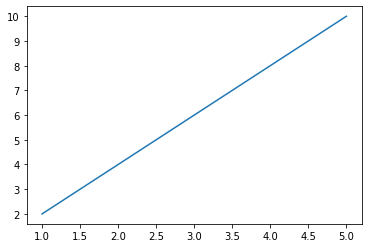

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

# Create some data
x = [1, 2, 3, 4, 5]
y = [2, 4, 6, 8, 10]

# Create a plot
plt.plot(x, y)

# Display the plot inline in the notebook
plt.show()


In this example, we first import the Matplotlib library and then execute the %matplotlib inline command to enable inline plotting. We then create some data and use the plt.plot() method to create a plot. Finally, we use the plt.show() method to display the plot inline in the notebook.

## 2. %matplotlib widget

The main difference between **%matplotlib widget** and **%matplotlib inline** is the way that the Matplotlib plots are displayed in the Jupyter Notebook.

With **%matplotlib inline**, the plots are displayed as *static images* directly in the output cells of the notebook. This means that the plots cannot be interacted with, and the user cannot modify or explore the data in the plot.

On the other hand, **%matplotlib widget** enables **interactive plots** within the Jupyter Notebook, allowing users to zoom, pan, and explore the data in the plot. When using %matplotlib widget, the plots are rendered using the ipympl library, which provides an interactive backend for Matplotlib.

In [17]:
import matplotlib.pyplot as plt
import os
os.system("pip install ipympl")
%matplotlib widget

# Create some data
x = [1, 2, 3, 4, 5]
y = [2, 4, 6, 8, 10]

# Create a plot
plt.plot(x, y)

# Display the plot interactively in the notebook
plt.show()

NotImplementedError: ignored

In this example, we import the Matplotlib library and then execute the %matplotlib widget command to enable interactive plotting. We then create some data and use the plt.plot() method to create a plot. Finally, we use the plt.show() method to display the plot interactively in the notebook.

It's important to note that %matplotlib widget requires a compatible backend, and may not work in all environments. Additionally, because interactive plots can be resource-intensive, they may be slower to render than static plots created using %matplotlib inline.

## 3. run bash commands with !

In [ ]:
!pip install ipympl

## 4. sionna.mapping

### 4.1 sn.mapping

In [ ]:
#
# SPDX-FileCopyrightText: Copyright (c) 2021-2022 NVIDIA CORPORATION & AFFILIATES. All rights reserved.
# SPDX-License-Identifier: Apache-2.0
#
"""Layers for (de)mapping, constellation class, and utility functions"""

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer
import matplotlib.pyplot as plt

import sionna as sn



def pam_gray(b):
    # pylint: disable=line-too-long
    r"""Maps a vector of bits to a PAM constellation points with Gray labeling.

    This recursive function maps a binary vector to Gray-labelled PAM
    constellation points. It can be used to generated QAM constellations.
    The constellation is not normalized.

    Input
    -----
    b : [n], NumPy array
        Tensor with with binary entries.

    Output
    ------
    : signed int
        The PAM constellation point taking values in
        :math:`\{\pm 1,\pm 3,\dots,\pm (2^n-1)\}`.

    Note
    ----
    This algorithm is a recursive implementation of the expressions found in
    Section 5.1 of [3GPPTS38211]_. It is used in the 5G standard.
    """ # pylint: disable=C0301

    if len(b)>1:
        return (1-2*b[0])*(2**len(b[1:]) - pam_gray(b[1:]))
    return 1-2*b[0]




def qam(num_bits_per_symbol, normalize=True):
    r"""Generates a QAM constellation.

    This function generates a complex-valued vector, where each element is
    a constellation point of an M-ary QAM constellation. The bit
    label of the ``n`` th point is given by the length-``num_bits_per_symbol``
    binary represenation of ``n``.

    Input
    -----
    num_bits_per_symbol : int
        The number of bits per constellation point.
        Must be a multiple of two, e.g., 2, 4, 6, 8, etc.

    normalize: bool
        If `True`, the constellation is normalized to have unit power.
        Defaults to `True`.

    Output
    ------
    : :math:`[2^{\text{num_bits_per_symbol}}]`, np.complex64
        The QAM constellation.

    Note
    ----
    The bit label of the nth constellation point is given by the binary
    representation of its position within the array and can be obtained
    through ``np.binary_repr(n, num_bits_per_symbol)``.


    The normalization factor of a QAM constellation is given in
    closed-form as:

    .. math::
        \sqrt{\frac{1}{2^{n-2}}\sum_{i=1}^{2^{n-1}}(2i-1)^2}

    where :math:`n= \text{num_bits_per_symbol}/2` is the number of bits
    per dimension.

    This algorithm is a recursive implementation of the expressions found in
    Section 5.1 of [3GPPTS38211]_. It is used in the 5G standard.
    """ # pylint: disable=C0301

    try:
        assert num_bits_per_symbol % 2 == 0 # is even
        assert num_bits_per_symbol >0 # is larger than zero
    except AssertionError as error:
        raise ValueError("num_bits_per_symbol must be a multiple of 2") \
        from error
    assert isinstance(normalize, bool), "normalize must be boolean"

    # Build constellation by iterating through all points
    c = np.zeros([2**num_bits_per_symbol], dtype=np.complex64)
    for i in range(0, 2**num_bits_per_symbol):
        b = np.array(list(np.binary_repr(i,num_bits_per_symbol)),
                     dtype=np.int16)
        c[i] = pam_gray(b[0::2]) + 1j*pam_gray(b[1::2]) # PAM in each dimension

    if normalize: # Normalize to unit energy
        n = int(num_bits_per_symbol/2)
        qam_var = 1/(2**(n-2))*np.sum(np.linspace(1,2**n-1, 2**(n-1))**2)
        c /= np.sqrt(qam_var)
    return c




def pam(num_bits_per_symbol, normalize=True):
    r"""Generates a PAM constellation.

    This function generates a real-valued vector, where each element is
    a constellation point of an M-ary PAM constellation. The bit
    label of the ``n`` th point is given by the length-``num_bits_per_symbol``
    binary represenation of ``n``.

    Input
    -----
    num_bits_per_symbol : int
        The number of bits per constellation point.
        Must be positive.

    normalize: bool
        If `True`, the constellation is normalized to have unit power.
        Defaults to `True`.

    Output
    ------
    : :math:`[2^{\text{num_bits_per_symbol}}]`, np.float32
        The PAM constellation.

    Note
    ----
    The bit label of the nth constellation point is given by the binary
    representation of its position within the array and can be obtained
    through ``np.binary_repr(n, num_bits_per_symbol)``.


    The normalization factor of a PAM constellation is given in
    closed-form as:

    .. math::
        \sqrt{\frac{1}{2^{n-1}}\sum_{i=1}^{2^{n-1}}(2i-1)^2}

    where :math:`n= \text{num_bits_per_symbol}` is the number of bits
    per symbol.

    This algorithm is a recursive implementation of the expressions found in
    Section 5.1 of [3GPPTS38211]_. It is used in the 5G standard.
    """ # pylint: disable=C0301

    try:
        assert num_bits_per_symbol >0 # is larger than zero
    except AssertionError as error:
        raise ValueError("num_bits_per_symbol must be positive") \
        from error
    assert isinstance(normalize, bool), "normalize must be boolean"

    # Build constellation by iterating through all points
    c = np.zeros([2**num_bits_per_symbol], dtype=np.float32)
    for i in range(0, 2**num_bits_per_symbol):
        b = np.array(list(np.binary_repr(i,num_bits_per_symbol)),
                     dtype=np.int16)
        c[i] = pam_gray(b)

    if normalize: # Normalize to unit energy
        n = int(num_bits_per_symbol)
        pam_var = 1/(2**(n-1))*np.sum(np.linspace(1,2**n-1, 2**(n-1))**2)
        c /= np.sqrt(pam_var)
    return c




class Constellation(Layer):
    # pylint: disable=line-too-long
    r"""
    Constellation(constellation_type, num_bits_per_symbol, initial_value=None, normalize=True, center=False, trainable=False, dtype=tf.complex64, **kwargs)

    Constellation that can be used by a (de)mapper.

    This class defines a constellation, i.e., a complex-valued vector of
    constellation points. A constellation can be trainable. The binary
    representation of the index of an element of this vector corresponds
    to the bit label of the constellation point. This implicit bit
    labeling is used by the ``Mapper`` and ``Demapper`` classes.

    Parameters
    ----------
    constellation_type : One of ["qam", "pam", "custom"], str
        For "custom", the constellation points are randomly initialized
        if no ``initial_value`` is provided.

    num_bits_per_symbol : int
        The number of bits per constellation symbol, e.g., 4 for QAM16.

    initial_value : :math:`[2^\text{num_bits_per_symbol}]`, NumPy array or Tensor
        Initial values of the constellation points. If ``normalize`` or
        ``center`` are `True`, the initial constellation might be changed.

    normalize : bool
        If `True`, the constellation is normalized to have unit power.
        Defaults to `True`.

    center : bool
        If `True`, the constellation is ensured to have zero mean.
        Defaults to `False`.

    trainable : bool
        If `True`, the constellation points are trainable variables.
        Defaults to `False`.

    dtype : [tf.complex64, tf.complex128], tf.DType
        The dtype of the constellation.

    Output
    ------
    : :math:`[2^\text{num_bits_per_symbol}]`, ``dtype``
        The constellation.

    Note
    ----
    One can create a trainable PAM/QAM constellation. This is
    equivalent to creating a custom trainable constellation which is
    initialized with PAM/QAM constellation points.
    """
    # pylint: enable=C0301

    def __init__(self,
                 constellation_type,
                 num_bits_per_symbol,
                 initial_value=None,
                 normalize=True,
                 center=False,
                 trainable=False,
                 dtype=tf.complex64,
                 **kwargs):
        super().__init__(**kwargs)
        assert dtype in [tf.complex64, tf.complex128],\
            "dtype must be tf.complex64 or tf.complex128"
        self._dtype = dtype

        assert constellation_type in ("qam", "pam", "custom"),\
            "Wrong constellation type"
        self._constellation_type = constellation_type

        assert isinstance(normalize, bool), "normalize must be boolean"
        self._normalize = normalize

        assert isinstance(center, bool), "center must be boolean"
        self._center = center

        assert isinstance(trainable, bool), "trainable must be boolean"
        self._trainable = trainable

        # allow float inputs that represent int
        assert isinstance(num_bits_per_symbol, (float,int)),\
            "num_bits_per_symbol must be integer"
        assert (num_bits_per_symbol%1==0),\
            "num_bits_per_symbol must be integer"
        num_bits_per_symbol = int(num_bits_per_symbol)

        if self._constellation_type=="qam":
            assert num_bits_per_symbol%2 == 0 and num_bits_per_symbol>0,\
                "num_bits_per_symbol must be a multiple of 2"
            self._num_bits_per_symbol = int(num_bits_per_symbol)

            assert initial_value is None, "QAM must not have an initial value"
            points = qam(self._num_bits_per_symbol, normalize=self.normalize)
            points = tf.cast(points, self._dtype)

        if self._constellation_type=="pam":
            assert num_bits_per_symbol>0,\
                "num_bits_per_symbol must be integer"
            self._num_bits_per_symbol = int(num_bits_per_symbol)

            assert initial_value is None, "PAM must not have an initial value"
            points = pam(self._num_bits_per_symbol, normalize=self.normalize)
            points = tf.cast(points, self._dtype)

        if self._constellation_type=="custom":
            assert num_bits_per_symbol>0,\
                "num_bits_per_symbol must be integer"
            self._num_bits_per_symbol = int(num_bits_per_symbol)

            # Randomly initialize points if no initial_value is provided
            if initial_value is None:
                points = tf.random.uniform(  # pylint: disable=E1123
                                        [2, 2**self._num_bits_per_symbol],
                                        minval=-0.05, maxval=0.05,
                                    dtype=tf.as_dtype(self._dtype).real_dtype)
                points  = tf.complex(points[0], points[1])
            else:
                assert tf.rank(initial_value).numpy() == 1
                assert tf.shape(initial_value)[0] == 2**num_bits_per_symbol,\
                    "initial_value must have shape [2**num_bits_per_symbol]"
                points = tf.cast(initial_value, self._dtype)
        self._points = points

    def build(self, input_shape): #pylint: disable=unused-argument
        points = self._points
        points = tf.stack([tf.math.real(points),
                           tf.math.imag(points)], axis=0)
        if self._trainable:
            self._points = tf.Variable(points,
                                       trainable=self._trainable,
                                    dtype=tf.as_dtype(self._dtype).real_dtype)
        else:
            self._points = tf.constant(points,
                                    dtype=tf.as_dtype(self._dtype).real_dtype)

    # pylint: disable=no-self-argument


    def create_or_check_constellation(  constellation_type=None,
                                        num_bits_per_symbol=None,
                                        constellation=None,
                                        dtype=tf.complex64):
        # pylint: disable=line-too-long
        r"""Static method for conviently creating a constellation object or checking that an existing one
        is consistent with requested settings.

        If ``constellation`` is `None`, then this method creates a :class:`~sionna.mapping.Constellation`
        object of type ``constellation_type`` and with ``num_bits_per_symbol`` bits per symbol.
        Otherwise, this method checks that `constellation` is consistent with ``constellation_type`` and
        ``num_bits_per_symbol``. If it is, ``constellation`` is returned. Otherwise, an assertion is raised.

        Input
        ------
        constellation_type : One of ["qam", "pam", "custom"], str
            For "custom", an instance of :class:`~sionna.mapping.Constellation`
            must be provided.

        num_bits_per_symbol : int
            The number of bits per constellation symbol, e.g., 4 for QAM16.
            Only required for ``constellation_type`` in ["qam", "pam"].

        constellation :  Constellation
            An instance of :class:`~sionna.mapping.Constellation` or
            `None`. In the latter case, ``constellation_type``
            and ``num_bits_per_symbol`` must be provided.

        Output
        -------
        : :class:`~sionna.mapping.Constellation`
            A constellation object.
        """
        constellation_object = None
        if constellation is not None:
            assert constellation_type in [None, "custom"], \
                """`constellation_type` must be "custom"."""
            assert num_bits_per_symbol in \
                     [None, constellation.num_bits_per_symbol], \
                """`Wrong value of `num_bits_per_symbol.`"""
            assert constellation.dtype==dtype, \
                "Constellation has wrong dtype."
            constellation_object = constellation
        else:
            assert constellation_type in ["qam", "pam"], \
                "Wrong constellation type."
            assert num_bits_per_symbol is not None, \
                "`num_bits_per_symbol` must be provided."
            constellation_object = Constellation(   constellation_type,
                                                    num_bits_per_symbol,
                                                    dtype=dtype)
        return constellation_object


    def call(self, inputs): #pylint: disable=unused-argument
        x = self._points
        x = tf.complex(x[0], x[1])
        if self._center:
            x = x - tf.reduce_mean(x)
        if self._normalize:
            energy = tf.reduce_mean(tf.square(tf.abs(x)))
            energy_sqrt = tf.cast(tf.sqrt(energy), self._dtype)
            x = x / energy_sqrt
        return x

    @property
    def normalize(self):
        """Indicates if the constellation is normalized or not."""
        return self._normalize

    @normalize.setter
    def normalize(self, value):
        assert isinstance(value, bool), "`normalize` must be boolean"
        self._normalize = value

    @property
    def center(self):
        """Indicates if the constellation is centered."""
        return self._center

    @center.setter
    def center(self, value):
        assert isinstance(value, bool), "`center` must be boolean"
        self._center = value

    @property
    def num_bits_per_symbol(self):
        """The number of bits per constellation symbol."""
        return self._num_bits_per_symbol

    @property
    def points(self):
        """The (possibly) centered and normalized constellation points."""
        return self(None)



    def show(self, labels=True, figsize=(7,7)):
        """Generate a scatter-plot of the constellation.

        Input
        -----
        labels : bool
            If `True`, the bit labels will be drawn next to each constellation
            point. Defaults to `True`.

        figsize : Two-element Tuple, float
            Width and height in inches. Defaults to `(7,7)`.

        Output
        ------
        : matplotlib.figure.Figure
            A handle to a matplot figure object.
        """
        maxval = np.max(np.abs(self.points))*1.05
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
        plt.xlim(-maxval, maxval)
        plt.ylim(-maxval, maxval)
        plt.scatter(np.real(self.points), np.imag(self.points))
        ax.set_aspect("equal", adjustable="box")
        plt.xlabel("Real Part")
        plt.ylabel("Imaginary Part")
        plt.grid(True, which="both", axis="both")
        plt.title("Constellation Plot")
        if labels is True:
            for j, p in enumerate(self.points.numpy()):
                plt.annotate(
                    np.binary_repr(j, self.num_bits_per_symbol),
                    (np.real(p), np.imag(p))
                )
        return fig




class Mapper(Layer):
    # pylint: disable=line-too-long
    r"""
    Mapper(constellation_type=None, num_bits_per_symbol=None, constellation=None, return_indices=False, dtype=tf.complex64, **kwargs)

    Maps binary tensors to points of a constellation.

    This class defines a layer that maps a tensor of binary values
    to a tensor of points from a provided constellation.

    Parameters
    ----------
    constellation_type : One of ["qam", "pam", "custom"], str
        For "custom", an instance of :class:`~sionna.mapping.Constellation`
        must be provided.

    num_bits_per_symbol : int
        The number of bits per constellation symbol, e.g., 4 for QAM16.
        Only required for ``constellation_type`` in ["qam", "pam"].

    constellation :  Constellation
        An instance of :class:`~sionna.mapping.Constellation` or
        `None`. In the latter case, ``constellation_type``
        and ``num_bits_per_symbol`` must be provided.

    return_indices : bool
        If enabled, symbol indices are additionally returned.
        Defaults to `False`.

    dtype : One of [tf.complex64, tf.complex128], tf.DType
        The output dtype. Defaults to tf.complex64.

    Input
    -----
    : [..., n], tf.float or tf.int
        Tensor with with binary entries.

    Output
    ------
    : [...,n/Constellation.num_bits_per_symbol], tf.complex
        The mapped constellation symbols.

    : [...,n/Constellation.num_bits_per_symbol], tf.int32
        The symbol indices corresponding to the constellation symbols.
        Only returned if ``return_indices`` is set to True.


    Note
    ----
    The last input dimension must be an integer multiple of the
    number of bits per constellation symbol.
    """
    def __init__(self,
                 constellation_type=None,
                 num_bits_per_symbol=None,
                 constellation=None,
                 return_indices=False,
                 dtype=tf.complex64,
                 **kwargs
                ):
        super().__init__(dtype=dtype, **kwargs)
        assert dtype in [tf.complex64, tf.complex128],\
            "dtype must be tf.complex64 or tf.complex128"

        # Create constellation object
        self._constellation = Constellation.create_or_check_constellation(
                                                        constellation_type,
                                                        num_bits_per_symbol,
                                                        constellation,
                                                        dtype=dtype)

        self._return_indices = return_indices

        self._binary_base = 2**tf.constant(
                        range(self.constellation.num_bits_per_symbol-1,-1,-1))

    @property
    def constellation(self):
        """The Constellation used by the Mapper."""
        return self._constellation

    def call(self, inputs):
        tf.debugging.assert_greater_equal(tf.rank(inputs), 2,
            message="The input must have at least rank 2")

        # Reshape inputs to the desired format
        new_shape = [-1] + inputs.shape[1:-1].as_list() + \
           [int(inputs.shape[-1] / self.constellation.num_bits_per_symbol),
            self.constellation.num_bits_per_symbol]
        inputs_reshaped = tf.cast(tf.reshape(inputs, new_shape), tf.int32)

        # Convert the last dimension to an integer
        int_rep = tf.reduce_sum(inputs_reshaped * self._binary_base, axis=-1)

        # Map integers to constellation symbols
        x = tf.gather(self.constellation.points, int_rep, axis=0)

        if self._return_indices:
            return x, int_rep
        else:
            return x




class SymbolLogits2LLRs(Layer):
    # pylint: disable=line-too-long
    r"""
    SymbolLogits2LLRs(method, num_bits_per_symbol, hard_out=False, with_prior=False, dtype=tf.float32, **kwargs)

    Computes log-likelihood ratios (LLRs) or hard-decisions on bits
    from a tensor of logits (i.e., unnormalized log-probabilities) on constellation points.
    If the flag ``with_prior`` is set, prior knowledge on the bits is assumed to be available.

    Parameters
    ----------
    method : One of ["app", "maxlog"], str
        The method used for computing the LLRs.

    num_bits_per_symbol : int
        The number of bits per constellation symbol, e.g., 4 for QAM16.

    hard_out : bool
        If `True`, the layer provides hard-decided bits instead of soft-values.
        Defaults to `False`.

    with_prior : bool
        If `True`, it is assumed that prior knowledge on the bits is available.
        This prior information is given as LLRs as an additional input to the layer.
        Defaults to `False`.

    dtype : One of [tf.float32, tf.float64] tf.DType (dtype)
        The dtype for the input and output.
        Defaults to `tf.float32`.

    Input
    -----
    logits or (logits, prior):
        Tuple:

    logits : [...,n, num_points], tf.float
        Logits on constellation points.

    prior : [num_bits_per_symbol] or [...n, num_bits_per_symbol], tf.float
        Prior for every bit as LLRs.
        It can be provided either as a tensor of shape `[num_bits_per_symbol]`
        for the entire input batch, or as a tensor that is "broadcastable"
        to `[..., n, num_bits_per_symbol]`.
        Only required if the ``with_prior`` flag is set.

    Output
    ------
    : [...,n, num_bits_per_symbol], tf.float
        LLRs or hard-decisions for every bit.

    Note
    ----
    With the "app" method, the LLR for the :math:`i\text{th}` bit
    is computed according to

    .. math::
        LLR(i) = \ln\left(\frac{\Pr\left(b_i=1\lvert \mathbf{z},\mathbf{p}\right)}{\Pr\left(b_i=0\lvert \mathbf{z},\mathbf{p}\right)}\right) =\ln\left(\frac{
                \sum_{c\in\mathcal{C}_{i,1}} \Pr\left(c\lvert\mathbf{p}\right)
                e^{z_c}
                }{
                \sum_{c\in\mathcal{C}_{i,0}} \Pr\left(c\lvert\mathbf{p}\right)
                e^{z_c}
                }\right)

    where :math:`\mathcal{C}_{i,1}` and :math:`\mathcal{C}_{i,0}` are the
    sets of :math:`2^K` constellation points for which the :math:`i\text{th}` bit is
    equal to 1 and 0, respectively. :math:`\mathbf{z} = \left[z_{c_0},\dots,z_{c_{2^K-1}}\right]` is the vector of logits on the constellation points, :math:`\mathbf{p} = \left[p_0,\dots,p_{K-1}\right]`
    is the vector of LLRs that serves as prior knowledge on the :math:`K` bits that are mapped to
    a constellation point and is set to :math:`\mathbf{0}` if no prior knowledge is assumed to be available,
    and :math:`\Pr(c\lvert\mathbf{p})` is the prior probability on the constellation symbol :math:`c`:

    .. math::
        \Pr\left(c\lvert\mathbf{p}\right) = \prod_{k=0}^{K-1} \Pr\left(b_k = \ell(c)_k \lvert\mathbf{p} \right)
        = \prod_{k=0}^{K-1} \text{sigmoid}\left(p_k \ell(c)_k\right)

    where :math:`\ell(c)_k` is the :math:`k^{th}` bit label of :math:`c`, where 0 is
    replaced by -1.
    The definition of the LLR has been
    chosen such that it is equivalent with that of logits. This is
    different from many textbooks in communications, where the LLR is
    defined as :math:`LLR(i) = \ln\left(\frac{\Pr\left(b_i=0\lvert y\right)}{\Pr\left(b_i=1\lvert y\right)}\right)`.

    With the "maxlog" method, LLRs for the :math:`i\text{th}` bit
    are approximated like

    .. math::
        \begin{align}
            LLR(i) &\approx\ln\left(\frac{
                \max_{c\in\mathcal{C}_{i,1}} \Pr\left(c\lvert\mathbf{p}\right)
                    e^{z_c}
                }{
                \max_{c\in\mathcal{C}_{i,0}} \Pr\left(c\lvert\mathbf{p}\right)
                    e^{z_c}
                }\right)
                .
        \end{align}
    """
    def __init__(self,
                 method,
                 num_bits_per_symbol,
                 hard_out=False,
                 with_prior=False,
                 dtype=tf.float32,
                 **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        assert method in ("app","maxlog"), "Unknown demapping method"
        self._method = method
        self._hard_out = hard_out
        self._num_bits_per_symbol = num_bits_per_symbol
        self._with_prior = with_prior
        num_points = int(2**num_bits_per_symbol)

        # Array composed of binary representations of all symbols indices
        a = np.zeros([num_points, num_bits_per_symbol])
        for i in range(0, num_points):
            a[i,:] = np.array(list(np.binary_repr(i, num_bits_per_symbol)),
                              dtype=np.int16)

        # Compute symbol indices for which the bits are 0 or 1
        c0 = np.zeros([int(num_points/2), num_bits_per_symbol])
        c1 = np.zeros([int(num_points/2), num_bits_per_symbol])
        for i in range(num_bits_per_symbol-1,-1,-1):
            c0[:,i] = np.where(a[:,i]==0)[0]
            c1[:,i] = np.where(a[:,i]==1)[0]
        self._c0 = tf.constant(c0, dtype=tf.int32) # Symbols with ith bit=0
        self._c1 = tf.constant(c1, dtype=tf.int32) # Symbols with ith bit=1

        if with_prior:
            # Array of labels from {-1, 1} of all symbols
            # [num_points, num_bits_per_symbol]
            a = 2*a-1
            self._a = tf.constant(a, dtype=dtype)

        # Determine the reduce function for LLR computation
        if self._method == "app":
            self._reduce = tf.reduce_logsumexp
        else:
            self._reduce = tf.reduce_max

    @property
    def num_bits_per_symbol(self):
        return self._num_bits_per_symbol

    def call(self, inputs):
        if self._with_prior:
            logits, prior = inputs
        else:
            logits = inputs

        # Compute exponents
        exponents = logits

        # Gather exponents for all bits
        # shape [...,n,num_points/2,num_bits_per_symbol]
        exp0 = tf.gather(exponents, self._c0, axis=-1, batch_dims=0)
        exp1 = tf.gather(exponents, self._c1, axis=-1, batch_dims=0)

        # Process the prior information
        if self._with_prior:
            # Expanding `prior` such that it is broadcastable with
            # shape [..., n or 1, 1, num_bits_per_symbol]
            prior = sn.utils.expand_to_rank(prior, tf.rank(logits), axis=0)
            prior = tf.expand_dims(prior, axis=-2)

            # Expand the symbol labeling to be broadcastable with prior
            # shape [..., 1, num_points, num_bits_per_symbol]
            a = sn.utils.expand_to_rank(self._a, tf.rank(prior), axis=0)

            # Compute the prior probabilities on symbols exponents
            # shape [..., n or 1, num_points]
            exp_ps = tf.reduce_sum(tf.math.log_sigmoid(a*prior), axis=-1)

            # Gather prior probability symbol for all bits
            # shape [..., n or 1, num_points/2, num_bits_per_symbol]
            exp_ps0 = tf.gather(exp_ps, self._c0, axis=-1)
            exp_ps1 = tf.gather(exp_ps, self._c1, axis=-1)

        # Compute LLRs using the definition log( Pr(b=1)/Pr(b=0) )
        # shape [..., n, num_bits_per_symbol]
        if self._with_prior:
            llr = self._reduce(exp_ps1 + exp1, axis=-2)\
                    - self._reduce(exp_ps0 + exp0, axis=-2)
        else:
            llr = self._reduce(exp1, axis=-2) - self._reduce(exp0, axis=-2)

        if self._hard_out:
            return sn.utils.hard_decisions(llr)
        else:
            return llr




class SymbolLogits2LLRsWithPrior(SymbolLogits2LLRs):
    # pylint: disable=line-too-long
    r"""
    SymbolLogits2LLRsWithPrior(method, num_bits_per_symbol, hard_out=False, dtype=tf.float32, **kwargs)

    Computes log-likelihood ratios (LLRs) or hard-decisions on bits
    from a tensor of logits (i.e., unnormalized log-probabilities) on constellation points,
    assuming that prior knowledge on the bits is available.

    This class is deprecated as the functionality has been integrated
    into :class:`~sionna.mapping.SymbolLogits2LLRs`.

    Parameters
    ----------
    method : One of ["app", "maxlog"], str
        The method used for computing the LLRs.

    num_bits_per_symbol : int
        The number of bits per constellation symbol, e.g., 4 for QAM16.

    hard_out : bool
        If `True`, the layer provides hard-decided bits instead of soft-values.
        Defaults to `False`.

    dtype : One of [tf.float32, tf.float64] tf.DType (dtype)
        The dtype for the input and output.
        Defaults to `tf.float32`.

    Input
    -----
    (logits, prior):
        Tuple:

    logits : [...,n, num_points], tf.float
        Logits on constellation points.

    prior : [num_bits_per_symbol] or [...n, num_bits_per_symbol], tf.float
        Prior for every bit as LLRs.
        It can be provided either as a tensor of shape `[num_bits_per_symbol]` for the
        entire input batch, or as a tensor that is "broadcastable"
        to `[..., n, num_bits_per_symbol]`.

    Output
    ------
    : [...,n, num_bits_per_symbol], tf.float
        LLRs or hard-decisions for every bit.

    Note
    ----
    With the "app" method, the LLR for the :math:`i\text{th}` bit
    is computed according to

    .. math::
        LLR(i) = \ln\left(\frac{\Pr\left(b_i=1\lvert \mathbf{z},\mathbf{p}\right)}{\Pr\left(b_i=0\lvert \mathbf{z},\mathbf{p}\right)}\right) =\ln\left(\frac{
                \sum_{c\in\mathcal{C}_{i,1}} \Pr\left(c\lvert\mathbf{p}\right)
                e^{z_c}
                }{
                \sum_{c\in\mathcal{C}_{i,0}} \Pr\left(c\lvert\mathbf{p}\right)
                e^{z_c}
                }\right)

    where :math:`\mathcal{C}_{i,1}` and :math:`\mathcal{C}_{i,0}` are the
    sets of :math:`2^K` constellation points for which the :math:`i\text{th}` bit is
    equal to 1 and 0, respectively. :math:`\mathbf{z} = \left[z_{c_0},\dots,z_{c_{2^K-1}}\right]` is the vector of logits on the constellation points, :math:`\mathbf{p} = \left[p_0,\dots,p_{K-1}\right]`
    is the vector of LLRs that serves as prior knowledge on the :math:`K` bits that are mapped to
    a constellation point,
    and :math:`\Pr(c\lvert\mathbf{p})` is the prior probability on the constellation symbol :math:`c`:

    .. math::
        \Pr\left(c\lvert\mathbf{p}\right) = \prod_{k=0}^{K-1} \Pr\left(b_k = \ell(c)_k \lvert\mathbf{p} \right)
        = \prod_{k=0}^{K-1} \text{sigmoid}\left(p_k \ell(c)_k\right)

    where :math:`\ell(c)_k` is the :math:`k^{th}` bit label of :math:`c`, where 0 is
    replaced by -1.
    The definition of the LLR has been
    chosen such that it is equivalent with that of logits. This is
    different from many textbooks in communications, where the LLR is
    defined as :math:`LLR(i) = \ln\left(\frac{\Pr\left(b_i=0\lvert y\right)}{\Pr\left(b_i=1\lvert y\right)}\right)`.

    With the "maxlog" method, LLRs for the :math:`i\text{th}` bit
    are approximated like

    .. math::
        \begin{align}
            LLR(i) &\approx\ln\left(\frac{
                \max_{c\in\mathcal{C}_{i,1}} \Pr\left(c\lvert\mathbf{p}\right)
                    e^{z_c}
                }{
                \max_{c\in\mathcal{C}_{i,0}} \Pr\left(c\lvert\mathbf{p}\right)
                    e^{z_c}
                }\right)
                .
        \end{align}
    """
    def __init__(self,
                 method,
                 num_bits_per_symbol,
                 hard_out=False,
                 dtype=tf.float32,
                 **kwargs):
        super().__init__(method=method,
                         num_bits_per_symbol=num_bits_per_symbol,
                         hard_out=False,
                         with_prior=True,
                         dtype=tf.float32,
                         **kwargs)




class Demapper(Layer):
    # pylint: disable=line-too-long
    r"""
    Demapper(demapping_method, constellation_type=None, num_bits_per_symbol=None, constellation=None, hard_out=False, with_prior=False, dtype=tf.complex64, **kwargs)

    Computes log-likelihood ratios (LLRs) or hard-decisions on bits
    for a tensor of received symbols.
    If the flag ``with_prior`` is set, prior knowledge on the bits is assumed to be available.

    This class defines a layer implementing different demapping
    functions. All demapping functions are fully differentiable when soft-decisions
    are computed.

    Parameters
    ----------
    demapping_method : One of ["app", "maxlog"], str
        The demapping method used.

    constellation_type : One of ["qam", "pam", "custom"], str
        For "custom", an instance of :class:`~sionna.mapping.Constellation`
        must be provided.

    num_bits_per_symbol : int
        The number of bits per constellation symbol, e.g., 4 for QAM16.
        Only required for ``constellation_type`` in ["qam", "pam"].

    constellation : Constellation
        An instance of :class:`~sionna.mapping.Constellation` or `None`.
        In the latter case, ``constellation_type``
        and ``num_bits_per_symbol`` must be provided.

    hard_out : bool
        If `True`, the demapper provides hard-decided bits instead of soft-values.
        Defaults to `False`.

    with_prior : bool
        If `True`, it is assumed that prior knowledge on the bits is available.
        This prior information is given as LLRs as an additional input to the layer.
        Defaults to `False`.

    dtype : One of [tf.complex64, tf.complex128] tf.DType (dtype)
        The dtype of `y`. Defaults to tf.complex64.
        The output dtype is the corresponding real dtype (tf.float32 or tf.float64).

    Input
    -----
    (y,no) or (y, prior, no) :
        Tuple:

    y : [...,n], tf.complex
        The received symbols.

    prior : [num_bits_per_symbol] or [...,num_bits_per_symbol], tf.float
        Prior for every bit as LLRs.
        It can be provided either as a tensor of shape `[num_bits_per_symbol]` for the
        entire input batch, or as a tensor that is "broadcastable"
        to `[..., n, num_bits_per_symbol]`.
        Only required if the ``with_prior`` flag is set.

    no : Scalar or [...,n], tf.float
        The noise variance estimate. It can be provided either as scalar
        for the entire input batch or as a tensor that is "broadcastable" to
        ``y``.

    Output
    ------
    : [...,n*num_bits_per_symbol], tf.float
        LLRs or hard-decisions for every bit.

    Note
    ----
    With the "app" demapping method, the LLR for the :math:`i\text{th}` bit
    is computed according to

    .. math::
        LLR(i) = \ln\left(\frac{\Pr\left(b_i=1\lvert y,\mathbf{p}\right)}{\Pr\left(b_i=0\lvert y,\mathbf{p}\right)}\right) =\ln\left(\frac{
                \sum_{c\in\mathcal{C}_{i,1}} \Pr\left(c\lvert\mathbf{p}\right)
                \exp\left(-\frac{1}{N_o}\left|y-c\right|^2\right)
                }{
                \sum_{c\in\mathcal{C}_{i,0}} \Pr\left(c\lvert\mathbf{p}\right)
                \exp\left(-\frac{1}{N_o}\left|y-c\right|^2\right)
                }\right)

    where :math:`\mathcal{C}_{i,1}` and :math:`\mathcal{C}_{i,0}` are the
    sets of constellation points for which the :math:`i\text{th}` bit is
    equal to 1 and 0, respectively. :math:`\mathbf{p} = \left[p_0,\dots,p_{K-1}\right]`
    is the vector of LLRs that serves as prior knowledge on the :math:`K` bits that are mapped to
    a constellation point and is set to :math:`\mathbf{0}` if no prior knowledge is assumed to be available,
    and :math:`\Pr(c\lvert\mathbf{p})` is the prior probability on the constellation symbol :math:`c`:

    .. math::
        \Pr\left(c\lvert\mathbf{p}\right) = \prod_{k=0}^{K-1} \text{sigmoid}\left(p_k \ell(c)_k\right)

    where :math:`\ell(c)_k` is the :math:`k^{th}` bit label of :math:`c`, where 0 is
    replaced by -1.
    The definition of the LLR has been
    chosen such that it is equivalent with that of logits. This is
    different from many textbooks in communications, where the LLR is
    defined as :math:`LLR(i) = \ln\left(\frac{\Pr\left(b_i=0\lvert y\right)}{\Pr\left(b_i=1\lvert y\right)}\right)`.

    With the "maxlog" demapping method, LLRs for the :math:`i\text{th}` bit
    are approximated like

    .. math::
        \begin{align}
            LLR(i) &\approx\ln\left(\frac{
                \max_{c\in\mathcal{C}_{i,1}} \Pr\left(c\lvert\mathbf{p}\right)
                    \exp\left(-\frac{1}{N_o}\left|y-c\right|^2\right)
                }{
                \max_{c\in\mathcal{C}_{i,0}} \Pr\left(c\lvert\mathbf{p}\right)
                    \exp\left(-\frac{1}{N_o}\left|y-c\right|^2\right)
                }\right)\\
                &= \max_{c\in\mathcal{C}_{i,0}}
                    \left(\ln\left(\Pr\left(c\lvert\mathbf{p}\right)\right)-\frac{|y-c|^2}{N_o}\right) -
                 \max_{c\in\mathcal{C}_{i,1}}\left( \ln\left(\Pr\left(c\lvert\mathbf{p}\right)\right) - \frac{|y-c|^2}{N_o}\right)
                .
        \end{align}
    """
    def __init__(self,
                 demapping_method,
                 constellation_type=None,
                 num_bits_per_symbol=None,
                 constellation=None,
                 hard_out=False,
                 with_prior=False,
                 dtype=tf.complex64,
                 **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        self._with_prior = with_prior


        # Create constellation object
        self._constellation = Constellation.create_or_check_constellation(
                                                        constellation_type,
                                                        num_bits_per_symbol,
                                                        constellation,
                                                        dtype=dtype)
        num_bits_per_symbol = self._constellation.num_bits_per_symbol

        self._logits2llrs = SymbolLogits2LLRs(demapping_method,
                                              num_bits_per_symbol,
                                              hard_out,
                                              with_prior,
                                              dtype.real_dtype,
                                              **kwargs)

    @property
    def constellation(self):
        return self._constellation

    def call(self, inputs):
        if self._with_prior:
            y, prior, no = inputs
        else:
            y, no = inputs

        # Reshape constellation points to [1,...1,num_points]
        points_shape = [1]*y.shape.rank + self.constellation.points.shape
        points = tf.reshape(self.constellation.points, points_shape)

        # Compute squared distances from y to all points
        # shape [...,n,num_points]
        squared_dist = tf.pow(tf.abs(tf.expand_dims(y, axis=-1) - points), 2)

        # Add a dummy dimension for broadcasting. This is not needed when no
        # is a scalar, but also does not do any harm.
        no = tf.expand_dims(no, axis=-1)

        # Compute exponents
        exponents = -squared_dist/no

        if self._with_prior:
            llr = self._logits2llrs([exponents, prior])
        else:
            llr = self._logits2llrs(exponents)

        # Reshape LLRs to [...,n*num_bits_per_symbol]
        out_shape = tf.concat([tf.shape(y)[:-1],
                               [y.shape[-1] * \
                                self.constellation.num_bits_per_symbol]], 0)
        llr_reshaped = tf.reshape(llr, out_shape)

        return llr_reshaped




class DemapperWithPrior(Demapper):
    # pylint: disable=line-too-long
    r"""
    DemapperWithPrior(demapping_method, constellation_type=None, num_bits_per_symbol=None, constellation=None, hard_out=False, dtype=tf.complex64, **kwargs)

    Computes log-likelihood ratios (LLRs) or hard-decisions on bits
    for a tensor of received symbols, assuming that prior knowledge on the bits is available.

    This class defines a layer implementing different demapping
    functions. All demapping functions are fully differentiable when soft-decisions
    are computed.

    This class is deprecated as the functionality has been integrated
    into :class:`~sionna.mapping.Demapper`.

    Parameters
    ----------
    demapping_method : One of ["app", "maxlog"], str
        The demapping method used.

    constellation_type : One of ["qam", "pam", "custom"], str
        For "custom", an instance of :class:`~sionna.mapping.Constellation`
        must be provided.

    num_bits_per_symbol : int
        The number of bits per constellation symbol, e.g., 4 for QAM16.
        Only required for ``constellation_type`` in ["qam", "pam"].

    constellation : Constellation
        An instance of :class:`~sionna.mapping.Constellation` or `None`.
        In the latter case, ``constellation_type``
        and ``num_bits_per_symbol`` must be provided.

    hard_out : bool
        If `True`, the demapper provides hard-decided bits instead of soft-values.
        Defaults to `False`.

    dtype : One of [tf.complex64, tf.complex128] tf.DType (dtype)
        The dtype of `y`. Defaults to tf.complex64.
        The output dtype is the corresponding real dtype (tf.float32 or tf.float64).

    Input
    -----
    (y, prior, no) :
        Tuple:

    y : [...,n], tf.complex
        The received symbols.

    prior : [num_bits_per_symbol] or [...,num_bits_per_symbol], tf.float
        Prior for every bit as LLRs.
        It can be provided either as a tensor of shape `[num_bits_per_symbol]` for the
        entire input batch, or as a tensor that is "broadcastable"
        to `[..., n, num_bits_per_symbol]`.

    no : Scalar or [...,n], tf.float
        The noise variance estimate. It can be provided either as scalar
        for the entire input batch or as a tensor that is "broadcastable" to
        ``y``.

    Output
    ------
    : [...,n*num_bits_per_symbol], tf.float
        LLRs or hard-decisions for every bit.

    Note
    ----
    With the "app" demapping method, the LLR for the :math:`i\text{th}` bit
    is computed according to

    .. math::
        LLR(i) = \ln\left(\frac{\Pr\left(b_i=1\lvert y,\mathbf{p}\right)}{\Pr\left(b_i=0\lvert y,\mathbf{p}\right)}\right) =\ln\left(\frac{
                \sum_{c\in\mathcal{C}_{i,1}} \Pr\left(c\lvert\mathbf{p}\right)
                \exp\left(-\frac{1}{N_o}\left|y-c\right|^2\right)
                }{
                \sum_{c\in\mathcal{C}_{i,0}} \Pr\left(c\lvert\mathbf{p}\right)
                \exp\left(-\frac{1}{N_o}\left|y-c\right|^2\right)
                }\right)

    where :math:`\mathcal{C}_{i,1}` and :math:`\mathcal{C}_{i,0}` are the
    sets of constellation points for which the :math:`i\text{th}` bit is
    equal to 1 and 0, respectively. :math:`\mathbf{p} = \left[p_0,\dots,p_{K-1}\right]`
    is the vector of LLRs that serves as prior knowledge on the :math:`K` bits that are mapped to
    a constellation point,
    and :math:`\Pr(c\lvert\mathbf{p})` is the prior probability on the constellation symbol :math:`c`:

    .. math::
        \Pr\left(c\lvert\mathbf{p}\right) = \prod_{k=0}^{K-1} \text{sigmoid}\left(p_k \ell(c)_k\right)

    where :math:`\ell(c)_k` is the :math:`k^{th}` bit label of :math:`c`, where 0 is
    replaced by -1.
    The definition of the LLR has been
    chosen such that it is equivalent with that of logits. This is
    different from many textbooks in communications, where the LLR is
    defined as :math:`LLR(i) = \ln\left(\frac{\Pr\left(b_i=0\lvert y\right)}{\Pr\left(b_i=1\lvert y\right)}\right)`.

    With the "maxlog" demapping method, LLRs for the :math:`i\text{th}` bit
    are approximated like

    .. math::
        \begin{align}
            LLR(i) &\approx\ln\left(\frac{
                \max_{c\in\mathcal{C}_{i,1}} \Pr\left(c\lvert\mathbf{p}\right)
                    \exp\left(-\frac{1}{N_o}\left|y-c\right|^2\right)
                }{
                \max_{c\in\mathcal{C}_{i,0}} \Pr\left(c\lvert\mathbf{p}\right)
                    \exp\left(-\frac{1}{N_o}\left|y-c\right|^2\right)
                }\right)\\
                &= \max_{c\in\mathcal{C}_{i,0}}
                    \left(\ln\left(\Pr\left(c\lvert\mathbf{p}\right)\right)-\frac{|y-c|^2}{N_o}\right) -
                 \max_{c\in\mathcal{C}_{i,1}}\left( \ln\left(\Pr\left(c\lvert\mathbf{p}\right)\right) - \frac{|y-c|^2}{N_o}\right)
                .
        \end{align}
    """
    def __init__(self,
                 demapping_method,
                 constellation_type=None,
                 num_bits_per_symbol=None,
                 constellation=None,
                 hard_out=False,
                 dtype=tf.complex64,
                 **kwargs):
        super().__init__(demapping_method=demapping_method,
                         constellation_type=constellation_type,
                         num_bits_per_symbol=num_bits_per_symbol,
                         constellation=constellation,
                         hard_out=hard_out,
                         with_prior=True,
                         dtype=dtype,
                         **kwargs)




class SymbolDemapper(Layer):
    # pylint: disable=line-too-long
    r"""
    SymbolDemapper(constellation_type=None, num_bits_per_symbol=None, constellation=None, hard_out=False, with_prior=False, dtype=tf.complex64, **kwargs)

    Computes normalized log-probabilities (logits) or hard-decisions on symbols
    for a tensor of received symbols.
    If the ``with_prior`` flag is set, prior knowldge on the transmitted constellation points is assumed to be available.
    The demapping function is fully differentiable when soft-values are
    computed.

    Parameters
    ----------
    constellation_type : One of ["qam", "pam", "custom"], str
        For "custom", an instance of :class:`~sionna.mapping.Constellation`
        must be provided.

    num_bits_per_symbol : int
        The number of bits per constellation symbol, e.g., 4 for QAM16.
        Only required for ``constellation_type`` in ["qam", "pam"].

    constellation : Constellation
        An instance of :class:`~sionna.mapping.Constellation` or `None`.
        In the latter case, ``constellation_type``
        and ``num_bits_per_symbol`` must be provided.

    hard_out : bool
        If `True`, the demapper provides hard-decided symbols instead of soft-values.
        Defaults to `False`.

    with_prior : bool
        If `True`, it is assumed that prior knowledge on the constellation points is available.
        This prior information is given as log-probabilities (logits) as an additional input to the layer.
        Defaults to `False`.

    dtype : One of [tf.complex64, tf.complex128] tf.DType (dtype)
        The dtype of `y`. Defaults to tf.complex64.
        The output dtype is the corresponding real dtype (tf.float32 or tf.float64).

    Input
    -----
    (y, no) or (y, prior, no) :
        Tuple:

    y : [...,n], tf.complex
        The received symbols.

    prior : [num_points] or [...,num_points], tf.float
        Prior for every symbol as log-probabilities (logits).
        It can be provided either as a tensor of shape `[num_points]` for the
        entire input batch, or as a tensor that is "broadcastable"
        to `[..., n, num_points]`.
        Only required if the ``with_prior`` flag is set.

    no : Scalar or [...,n], tf.float
        The noise variance estimate. It can be provided either as scalar
        for the entire input batch or as a tensor that is "broadcastable" to
        ``y``.

    Output
    ------
    : [...,n, num_points] or [...,n], tf.float
        A tensor of shape `[...,n, num_points]` of logits for every constellation
        point if `hard_out` is set to `False`.
        Otherwise, a tensor of shape `[...,n]` of hard-decisions on the symbols.

    Note
    ----
    The normalized log-probability for the constellation point :math:`c` is computed according to

    .. math::
        \ln\left(\Pr\left(c \lvert y,\mathbf{p}\right)\right) = \ln\left( \frac{\exp\left(-\frac{|y-c|^2}{N_0} + p_c \right)}{\sum_{c'\in\mathcal{C}} \exp\left(-\frac{|y-c'|^2}{N_0} + p_{c'} \right)} \right)

    where :math:`\mathcal{C}` is the set of constellation points used for modulation,
    and :math:`\mathbf{p} = \left\{p_c \lvert c \in \mathcal{C}\right\}` the prior information on constellation points given as log-probabilities
    and which is set to :math:`\mathbf{0}` if no prior information on the constellation points is assumed to be available.
    """
    def __init__(self,
                 constellation_type=None,
                 num_bits_per_symbol=None,
                 constellation=None,
                 hard_out=False,
                 with_prior=False,
                 dtype=tf.complex64,
                 **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        self._hard_out = hard_out
        self._with_prior = with_prior

        # Create constellation object
        self._constellation = Constellation.create_or_check_constellation(
                                                        constellation_type,
                                                        num_bits_per_symbol,
                                                        constellation,
                                                        dtype=dtype)

    def call(self, inputs):
        if self._with_prior:
            y, prior, no = inputs
        else:
            y, no = inputs

        points = sn.utils.expand_to_rank(self._constellation.points,
                                tf.rank(y)+1, axis=0)
        y = tf.expand_dims(y, axis=-1)
        d = tf.abs(y-points)

        no = sn.utils.expand_to_rank(no, tf.rank(d), axis=-1)
        exp = -d**2 / no

        if self._with_prior:
            prior = sn.utils.expand_to_rank(prior, tf.rank(exp), axis=0)
            exp = exp + prior

        if self._hard_out:
            return tf.argmax(exp, axis=-1, output_type=tf.int32)
        else:
            return tf.nn.log_softmax(exp, axis=-1)




class SymbolDemapperWithPrior(SymbolDemapper):
    # pylint: disable=line-too-long
    r"""
    SymbolDemapperWithPrior(constellation_type=None, num_bits_per_symbol=None, constellation=None, hard_out=False, dtype=tf.complex64, **kwargs)

    Computes normalized log-probabilities (logits) or hard-decisions on symbols
    for a tensor of received symbols, assuming that prior knowledge on the constellation points is available.
    The demapping function is fully differentiable when soft-values are
    computed.

    This class is deprecated as the functionality has been integrated
    into :class:`~sionna.mapping.SymbolDemapper`.

    Parameters
    ----------
    constellation_type : One of ["qam", "pam", "custom"], str
        For "custom", an instance of :class:`~sionna.mapping.Constellation`
        must be provided.

    num_bits_per_symbol : int
        The number of bits per constellation symbol, e.g., 4 for QAM16.
        Only required for ``constellation_type`` in ["qam", "pam"].

    constellation : Constellation
        An instance of :class:`~sionna.mapping.Constellation` or `None`.
        In the latter case, ``constellation_type``
        and ``num_bits_per_symbol`` must be provided.

    hard_out : bool
        If `True`, the demapper provides hard-decided symbols instead of soft-values.
        Defaults to `False`.

    dtype : One of [tf.complex64, tf.complex128] tf.DType (dtype)
        The dtype of `y`. Defaults to tf.complex64.
        The output dtype is the corresponding real dtype (tf.float32 or tf.float64).

    Input
    -----
    (y, prior, no) :
        Tuple:

    y : [...,n], tf.complex
        The received symbols.

    prior : [num_points] or [...,num_points], tf.float
        Prior for every symbol as log-probabilities (logits).
        It can be provided either as a tensor of shape `[num_points]` for the
        entire input batch, or as a tensor that is "broadcastable"
        to `[..., n, num_points]`.

    no : Scalar or [...,n], tf.float
        The noise variance estimate. It can be provided either as scalar
        for the entire input batch or as a tensor that is "broadcastable" to
        ``y``.

    Output
    ------
    : [...,n, num_points] or [...,n], tf.float
        A tensor of shape `[...,n, num_points]` of logits for every constellation
        point if `hard_out` is set to `False`.
        Otherwise, a tensor of shape `[...,n]` of hard-decisions on the symbols.

    Note
    ----
    The normalized log-probability for the constellation point :math:`c` is computed according to

    .. math::
        \ln\left(\Pr\left(c \lvert y,\mathbf{p}\right)\right) = \ln\left( \frac{\exp\left(-\frac{|y-c|^2}{N_0} + p_c \right)}{\sum_{c'\in\mathcal{C}} \exp\left(-\frac{|y-c'|^2}{N_0} + p_{c'} \right)} \right)

    where :math:`\mathcal{C}` is the set of constellation points used for modulation,
    and :math:`\mathbf{p} = \left\{p_c \lvert c \in \mathcal{C}\right\}` the prior information on constellation points given as log-probabilities.
    """
    def __init__(self,
                 constellation_type=None,
                 num_bits_per_symbol=None,
                 constellation=None,
                 hard_out=False,
                 dtype=tf.complex64,
                 **kwargs):
        super().__init__(constellation_type=constellation_type,
                         num_bits_per_symbol=num_bits_per_symbol,
                         constellation=constellation,
                         hard_out=hard_out,
                         with_prior=True,
                         dtype=dtype,
                         **kwargs)




class LLRs2SymbolLogits(Layer):
    # pylint: disable=line-too-long
    r"""
    LLRs2SymbolLogits(num_bits_per_symbol, hard_out=False, dtype=tf.float32, **kwargs)

    Computes logits (i.e., unnormalized log-probabilities) or hard decisions
    on constellation points from a tensor of log-likelihood ratios (LLRs) on bits.

    Parameters
    ----------
    num_bits_per_symbol : int
        The number of bits per constellation symbol, e.g., 4 for QAM16.

    hard_out : bool
        If `True`, the layer provides hard-decided constellation points instead of soft-values.
        Defaults to `False`.

    dtype : One of [tf.float32, tf.float64] tf.DType (dtype)
        The dtype for the input and output.
        Defaults to `tf.float32`.

    Input
    -----
    llrs : [..., n, num_bits_per_symbol], tf.float
        LLRs for every bit.

    Output
    ------
    : [...,n, num_points], tf.float or [..., n], tf.int32
        Logits or hard-decisions on constellation points.

    Note
    ----
    The logit for the constellation :math:`c` point
    is computed according to

    .. math::
        \begin{align}
            \log{\left(\Pr\left(c\lvert LLRs \right)\right)}
                &= \log{\left(\prod_{k=0}^{K-1} \Pr\left(b_k = \ell(c)_k \lvert LLRs \right)\right)}\\
                &= \log{\left(\prod_{k=0}^{K-1} \text{sigmoid}\left(LLR(k) \ell(c)_k\right)\right)}\\
                &= \sum_{k=0}^{K-1} \log{\left(\text{sigmoid}\left(LLR(k) \ell(c)_k\right)\right)}
        \end{align}

    where :math:`\ell(c)_k` is the :math:`k^{th}` bit label of :math:`c`, where 0 is
    replaced by -1.
    The definition of the LLR has been
    chosen such that it is equivalent with that of logits. This is
    different from many textbooks in communications, where the LLR is
    defined as :math:`LLR(i) = \ln\left(\frac{\Pr\left(b_i=0\lvert y\right)}{\Pr\left(b_i=1\lvert y\right)}\right)`.
    """

    def __init__(self,
                 num_bits_per_symbol,
                 hard_out=False,
                 dtype=tf.float32,
                 **kwargs):
        super().__init__(dtype=dtype, **kwargs)

        self._hard_out = hard_out
        self._num_bits_per_symbol = num_bits_per_symbol
        num_points = int(2**num_bits_per_symbol)

        # Array composed of binary representations of all symbols indices
        a = np.zeros([num_points, num_bits_per_symbol])
        for i in range(0, num_points):
            a[i,:] = np.array(list(np.binary_repr(i, num_bits_per_symbol)),
                              dtype=np.int16)

        # Array of labels from {-1, 1} of all symbols
        # [num_points, num_bits_per_symbol]
        a = 2*a-1
        self._a = tf.constant(a, dtype=dtype)

    @property
    def num_bits_per_symbol(self):
        return self._num_bits_per_symbol

    def call(self, inputs):
        llrs = inputs

        # Expand the symbol labeling to be broadcastable with prior
        # shape [1, ..., 1, num_points, num_bits_per_symbol]
        a = sn.utils.expand_to_rank(self._a, tf.rank(llrs), axis=0)

        # Compute the prior probabilities on symbols exponents
        # shape [..., 1, num_points]
        llrs = tf.expand_dims(llrs, axis=-2)
        logits = tf.reduce_sum(tf.math.log_sigmoid(a*llrs), axis=-1)

        if self._hard_out:
            return tf.argmax(logits, axis=-1, output_type=tf.int32)
        else:
            return logits




class SymbolLogits2Moments(Layer):
    # pylint: disable=line-too-long
    r"""
    SymbolLogits2Moments(constellation_type=None, num_bits_per_symbol=None, constellation=None, dtype=tf.float32, **kwargs)

    Computes the mean and variance of a constellation from logits (unnormalized log-probabilities) on the
    constellation points.

    More precisely, given a constellation :math:`\mathcal{C} = \left[ c_0,\dots,c_{N-1} \right]` of size :math:`N`, this layer computes the mean and variance
    according to

    .. math::
        \begin{align}
            \mu &= \sum_{n = 0}^{N-1} c_n \Pr \left(c_n \lvert \mathbf{\ell} \right)\\
            \nu &= \sum_{n = 0}^{N-1} \left( c_n - \mu \right)^2 \Pr \left(c_n \lvert \mathbf{\ell} \right)
        \end{align}


    where :math:`\mathbf{\ell} = \left[ \ell_0, \dots, \ell_{N-1} \right]` are the logits, and

    .. math::
        \Pr \left(c_n \lvert \mathbf{\ell} \right) = \frac{\exp \left( \ell_n \right)}{\sum_{i=0}^{N-1} \exp \left( \ell_i \right) }.

    Parameters
    ----------
    constellation_type : One of ["qam", "pam", "custom"], str
        For "custom", an instance of :class:`~sionna.mapping.Constellation`
        must be provided.

    num_bits_per_symbol : int
        The number of bits per constellation symbol, e.g., 4 for QAM16.
        Only required for ``constellation_type`` in ["qam", "pam"].

    constellation : Constellation
        An instance of :class:`~sionna.mapping.Constellation` or `None`.
        In the latter case, ``constellation_type``
        and ``num_bits_per_symbol`` must be provided.

    dtype : One of [tf.float32, tf.float64] tf.DType (dtype)
        The dtype for the input and output.
        Defaults to `tf.float32`.

    Input
    -----
    logits : [...,n, num_points], tf.float
        Logits on constellation points.

    Output
    ------
    mean : [...,n], tf.float
        Mean of the constellation.

    var : [...,n], tf.float
        Variance of the constellation
    """
    def __init__(self,
                 constellation_type=None,
                 num_bits_per_symbol=None,
                 constellation=None,
                 dtype=tf.float32,
                 **kwargs):
        super().__init__(dtype=dtype, **kwargs)

        # Create constellation object
        const_dtype = tf.complex64 if dtype is tf.float32 else tf.complex128
        self._constellation = Constellation.create_or_check_constellation(
                                                        constellation_type,
                                                        num_bits_per_symbol,
                                                        constellation,
                                                        dtype=const_dtype)

    def __call__(self, logits):
        p = tf.math.softmax(logits, axis=-1)
        p_c = tf.complex(p, tf.cast(0.0, self.dtype))
        points = self._constellation.points
        points = sn.utils.expand_to_rank(points, tf.rank(p), axis=0)

        mean = tf.reduce_sum(p_c*points, axis=-1, keepdims=True)
        var = tf.reduce_sum(p*tf.square(tf.abs(points - mean)), axis=-1)
        mean = tf.squeeze(mean, axis=-1)

        return mean, var




class QAM2PAM:
    r"""Transforms QAM symbol indices to PAM symbol indices.

    For indices in a QAM constellation, computes the corresponding indices
    for the two PAM constellations corresponding the real and imaginary
    components of the QAM constellation.

    Parameters
    ----------
    num_bits_per_symbol : int
        The number of bits per QAM constellation symbol, e.g., 4 for QAM16.

    Input
    -----
    ind_qam : Tensor, tf.int
        Indices in the QAM constellation

    Output
    -------
    ind_pam1 : Tensor, tf.int
        Indices for the first component of the corresponding PAM modulation

    ind_pam2 : Tensor, tf.int
        Indices for the first component of the corresponding PAM modulation
    """
    def __init__(self, num_bits_per_symbol):
        base = [2**i for i in range(num_bits_per_symbol//2-1, -1, -1)]
        base = np.array(base)
        pam1_ind = np.zeros([2**num_bits_per_symbol], dtype=np.int32)
        pam2_ind = np.zeros([2**num_bits_per_symbol], dtype=np.int32)
        for i in range(0, 2**num_bits_per_symbol):
            b = np.array(list(np.binary_repr(i,num_bits_per_symbol)),
                         dtype=np.int32)
            pam1_ind[i] = np.sum(b[0::2]*base)
            pam2_ind[i] = np.sum(b[1::2]*base)
        self._pam1_ind = tf.constant(pam1_ind, dtype=tf.int32)
        self._pam2_ind = tf.constant(pam2_ind, dtype=tf.int32)

    def __call__(self, ind_qam):

        ind_pam1 = tf.gather(self._pam1_ind, ind_qam, axis=0)
        ind_pam2 = tf.gather(self._pam2_ind, ind_qam, axis=0)

        return ind_pam1, ind_pam2




class PAM2QAM:
    r"""Transforms PAM symbol indices/logits to QAM symbol indices/logits.

    For two PAM constellation symbol indices or logits, corresponding to
    the real and imaginary components of a QAM constellation,
    compute the QAM symbol index or logits.

    Parameters
    ----------
    num_bits_per_symbol : int
        Number of bits per QAM constellation symbol, e.g., 4 for QAM16

    hard_in_out : bool
        Determines if inputs and outputs are indices or logits over
        constellation symbols.
        Defaults to `True`.

    Input
    -----
    pam1 : Tensor, tf.int, or [...,2**(num_bits_per_symbol/2)], tf.float
        Indices or logits for the first PAM constellation

    pam2 : Tensor, tf.int, or [...,2**(num_bits_per_symbol/2)], tf.float
        Indices or logits for the second PAM constellation

    Output
    -------
    qam : Tensor, tf.int, or [...,2**num_bits_per_symbol], tf.float
        Indices or logits for the corresponding QAM constellation
    """
    def __init__(self, num_bits_per_symbol, hard_in_out=True):
        num_pam_symbols = 2**(num_bits_per_symbol//2)
        base = np.array([2**i for i in range(num_bits_per_symbol-1, -1, -1)])

        # Create an array of QAM symbol indices, index by two PAM indices
        ind = np.zeros([num_pam_symbols, num_pam_symbols], np.int32)
        for i in range(0, num_pam_symbols):
            for j in range(0, num_pam_symbols):
                b1 = np.array(list(np.binary_repr(i,num_bits_per_symbol//2)),
                              dtype=np.int16)
                b2 = np.array(list(np.binary_repr(j,num_bits_per_symbol//2)),
                              dtype=np.int16)
                b = np.zeros([num_bits_per_symbol], np.int32)
                b[0::2] = b1
                b[1::2] = b2
                ind[i, j] = np.sum(b*base)
        self._qam_ind = tf.constant(ind, dtype=tf.int32)
        self._hard_in_out = hard_in_out

    def __call__(self, pam1, pam2):

        # PAM indices to QAM indices
        if self._hard_in_out:
            shape = tf.shape(pam1)
            ind_pam1 = tf.reshape(pam1, [-1, 1])
            ind_pam2 = tf.reshape(pam2, [-1, 1])
            ind_pam = tf.concat([ind_pam1, ind_pam2], axis=-1)
            ind_qam = tf.gather_nd(self._qam_ind, ind_pam)
            ind_qam = tf.reshape(ind_qam, shape)
            return ind_qam

        # PAM logits to QAM logits
        else:
            # Compute all combination of sums of logits
            logits_mat = tf.expand_dims(pam1, -1) + tf.expand_dims(pam2, -2)

            # Flatten to a vector
            logits = sn.utils.flatten_last_dims(logits_mat)

            # Gather symbols in the correct order
            gather_ind = tf.reshape(self._qam_ind, [-1])
            logits = tf.gather(logits, gather_ind, axis=-1)
            return logits




class SymbolInds2Bits(Layer):
    # pylint: disable=line-too-long
    r"""SymbolInds2Bits(num_bits_per_symbol, dtype=tf.float32, **kwargs)

    Transforms symbol indices to their binary representations.

    Parameters
    ----------
    num_bits_per_symbol : int
        Number of bits per constellation symbol

    dtype: tf.DType
        Output dtype. Defaults to `tf.float32`.

    Input
    -----
    : Tensor, tf.int
        Symbol indices

    Output
    -----
    : input.shape + [num_bits_per_symbol], dtype
        Binary representation of symbol indices
    """
    def __init__(self,
               num_bits_per_symbol,
               dtype=tf.float32,
               **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        num_symbols = 2**num_bits_per_symbol
        b = np.zeros([num_symbols, num_bits_per_symbol])
        for i in range(0, num_symbols):
            b[i,:] = np.array(list(np.binary_repr(i, num_bits_per_symbol)),
                              dtype=np.int16)
        self._bit_labels = tf.constant(b, self.dtype)

    def call(self, inputs):
        symbol_ind = inputs
        return tf.gather(self._bit_labels, symbol_ind)


### 4.2 sn.mapping.Constellation

In [ ]:
class Constellation(Layer):
    # pylint: disable=line-too-long
    r"""
    Constellation(constellation_type, num_bits_per_symbol, initial_value=None, normalize=True, center=False, trainable=False, dtype=tf.complex64, **kwargs)

    Constellation that can be used by a (de)mapper.

    This class defines a constellation, i.e., a complex-valued vector of
    constellation points. A constellation can be trainable. The binary
    representation of the index of an element of this vector corresponds
    to the bit label of the constellation point. This implicit bit
    labeling is used by the ``Mapper`` and ``Demapper`` classes.

    Parameters
    ----------
    constellation_type : One of ["qam", "pam", "custom"], str
        For "custom", the constellation points are randomly initialized
        if no ``initial_value`` is provided.

    num_bits_per_symbol : int
        The number of bits per constellation symbol, e.g., 4 for QAM16.

    initial_value : :math:`[2^\text{num_bits_per_symbol}]`, NumPy array or Tensor
        Initial values of the constellation points. If ``normalize`` or
        ``center`` are `True`, the initial constellation might be changed.

    normalize : bool
        If `True`, the constellation is normalized to have unit power.
        Defaults to `True`.

    center : bool
        If `True`, the constellation is ensured to have zero mean.
        Defaults to `False`.

    trainable : bool
        If `True`, the constellation points are trainable variables.
        Defaults to `False`.

    dtype : [tf.complex64, tf.complex128], tf.DType
        The dtype of the constellation.

    Output
    ------
    : :math:`[2^\text{num_bits_per_symbol}]`, ``dtype``
        The constellation.

    Note
    ----
    One can create a trainable PAM/QAM constellation. This is
    equivalent to creating a custom trainable constellation which is
    initialized with PAM/QAM constellation points.
    """
    # pylint: enable=C0301

    def __init__(self,
                 constellation_type,
                 num_bits_per_symbol,
                 initial_value=None,
                 normalize=True,
                 center=False,
                 trainable=False,
                 dtype=tf.complex64,
                 **kwargs):
### super().__init__(**kwargs): calls the constructor of the base class with the
### keyword arguments 'kwargs' to initialize the base class from the derived class.
### By using **kwargs, the keyword arguments passed to the derived class 
### constructor can be passed to the base class constructor as well, without 
### having to explicitly list them.
        super().__init__(**kwargs)

### <Keyword 'assert'>
### Syntax: assert condition, message
### Checks a condition true or false and raises an 'AssertionError' when false.
### e.g: assert b != 0, "Cannot divide by zero"

### <Keyword 'in'>
### Syntax: value in sequence
### If the value is found in the sequence, in returns True. Otherwise, False.
        assert dtype in [tf.complex64, tf.complex128],\
            "dtype must be tf.complex64 or tf.complex128"
        self._dtype = dtype

        assert constellation_type in ("qam", "pam", "custom"),\
            "Wrong constellation type"
        self._constellation_type = constellation_type

### <Function 'isinstance()'>
### Syntax: isinstance(object, classinfo)
### Checks if an object is an instance of a specific class. Returns True if 
### the object is an instance of the specified class or a subclass of 
### the specified class. Otherwise, False.
        assert isinstance(normalize, bool), "normalize must be boolean"
        self._normalize = normalize

        assert isinstance(center, bool), "center must be boolean"
        self._center = center

        assert isinstance(trainable, bool), "trainable must be boolean"
        self._trainable = trainable

        # allow float inputs that represent int
        assert isinstance(num_bits_per_symbol, (float,int)),\
            "num_bits_per_symbol must be integer"
        assert (num_bits_per_symbol%1==0),\
            "num_bits_per_symbol must be integer"
        num_bits_per_symbol = int(num_bits_per_symbol)

        if self._constellation_type=="qam":
            assert num_bits_per_symbol%2 == 0 and num_bits_per_symbol>0,\
                "num_bits_per_symbol must be a multiple of 2"
            self._num_bits_per_symbol = int(num_bits_per_symbol)

            assert initial_value is None, "QAM must not have an initial value"
            points = qam(self._num_bits_per_symbol, normalize=self.normalize)
            points = tf.cast(points, self._dtype)

        if self._constellation_type=="pam":
            assert num_bits_per_symbol>0,\
                "num_bits_per_symbol must be integer"
            self._num_bits_per_symbol = int(num_bits_per_symbol)

            assert initial_value is None, "PAM must not have an initial value"
            points = pam(self._num_bits_per_symbol, normalize=self.normalize)
            points = tf.cast(points, self._dtype)

        if self._constellation_type=="custom":
            assert num_bits_per_symbol>0,\
                "num_bits_per_symbol must be integer"
            self._num_bits_per_symbol = int(num_bits_per_symbol)

            # Randomly initialize points if no initial_value is provided
            if initial_value is None:
                points = tf.random.uniform(  # pylint: disable=E1123
                                        [2, 2**self._num_bits_per_symbol],
                                        minval=-0.05, maxval=0.05,
                                    dtype=tf.as_dtype(self._dtype).real_dtype)
                points  = tf.complex(points[0], points[1])
            else:
                assert tf.rank(initial_value).numpy() == 1
                assert tf.shape(initial_value)[0] == 2**num_bits_per_symbol,\
                    "initial_value must have shape [2**num_bits_per_symbol]"
                points = tf.cast(initial_value, self._dtype)
        self._points = points

    def build(self, input_shape): #pylint: disable=unused-argument
        points = self._points
        points = tf.stack([tf.math.real(points),
                           tf.math.imag(points)], axis=0)
        if self._trainable:
            self._points = tf.Variable(points,
                                       trainable=self._trainable,
                                    dtype=tf.as_dtype(self._dtype).real_dtype)
        else:
            self._points = tf.constant(points,
                                    dtype=tf.as_dtype(self._dtype).real_dtype)

    # pylint: disable=no-self-argument

    def create_or_check_constellation(  constellation_type=None,
                                        num_bits_per_symbol=None,
                                        constellation=None,
                                        dtype=tf.complex64):
        # pylint: disable=line-too-long
        r"""Static method for conviently creating a constellation object or checking that an existing one
        is consistent with requested settings.

        If ``constellation`` is `None`, then this method creates a :class:`~sionna.mapping.Constellation`
        object of type ``constellation_type`` and with ``num_bits_per_symbol`` bits per symbol.
        Otherwise, this method checks that `constellation` is consistent with ``constellation_type`` and
        ``num_bits_per_symbol``. If it is, ``constellation`` is returned. Otherwise, an assertion is raised.

        Input
        ------
        constellation_type : One of ["qam", "pam", "custom"], str
            For "custom", an instance of :class:`~sionna.mapping.Constellation`
            must be provided.

        num_bits_per_symbol : int
            The number of bits per constellation symbol, e.g., 4 for QAM16.
            Only required for ``constellation_type`` in ["qam", "pam"].

        constellation :  Constellation
            An instance of :class:`~sionna.mapping.Constellation` or
            `None`. In the latter case, ``constellation_type``
            and ``num_bits_per_symbol`` must be provided.

        Output
        -------
        : :class:`~sionna.mapping.Constellation`
            A constellation object.
        """
        constellation_object = None
        if constellation is not None:
            assert constellation_type in [None, "custom"], \
                """`constellation_type` must be "custom"."""
            assert num_bits_per_symbol in \
                     [None, constellation.num_bits_per_symbol], \
                """`Wrong value of `num_bits_per_symbol.`"""
            assert constellation.dtype==dtype, \
                "Constellation has wrong dtype."
            constellation_object = constellation
        else:
            assert constellation_type in ["qam", "pam"], \
                "Wrong constellation type."
            assert num_bits_per_symbol is not None, \
                "`num_bits_per_symbol` must be provided."
            constellation_object = Constellation(   constellation_type,
                                                    num_bits_per_symbol,
                                                    dtype=dtype)
        return constellation_object


    def call(self, inputs): #pylint: disable=unused-argument
        x = self._points
        x = tf.complex(x[0], x[1])
        if self._center:
            x = x - tf.reduce_mean(x)
        if self._normalize:
            energy = tf.reduce_mean(tf.square(tf.abs(x)))
            energy_sqrt = tf.cast(tf.sqrt(energy), self._dtype)
            x = x / energy_sqrt
        return x

    @property
    def normalize(self):
        """Indicates if the constellation is normalized or not."""
        return self._normalize

    @normalize.setter
    def normalize(self, value):
        assert isinstance(value, bool), "`normalize` must be boolean"
        self._normalize = value

    @property
    def center(self):
        """Indicates if the constellation is centered."""
        return self._center

    @center.setter
    def center(self, value):
        assert isinstance(value, bool), "`center` must be boolean"
        self._center = value

    @property
    def num_bits_per_symbol(self):
        """The number of bits per constellation symbol."""
        return self._num_bits_per_symbol

    @property
    def points(self):
        """The (possibly) centered and normalized constellation points."""
        return self(None)


    def show(self, labels=True, figsize=(7,7)):
        """Generate a scatter-plot of the constellation.

        Input
        -----
        labels : bool
            If `True`, the bit labels will be drawn next to each constellation
            point. Defaults to `True`.

        figsize : Two-element Tuple, float
            Width and height in inches. Defaults to `(7,7)`.

        Output
        ------
        : matplotlib.figure.Figure
            A handle to a matplot figure object.
        """
        maxval = np.max(np.abs(self.points))*1.05
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
        plt.xlim(-maxval, maxval)
        plt.ylim(-maxval, maxval)
        plt.scatter(np.real(self.points), np.imag(self.points))
        ax.set_aspect("equal", adjustable="box")
        plt.xlabel("Real Part")
        plt.ylabel("Imaginary Part")
        plt.grid(True, which="both", axis="both")
        plt.title("Constellation Plot")
        if labels is True:
            for j, p in enumerate(self.points.numpy()):
                plt.annotate(
                    np.binary_repr(j, self.num_bits_per_symbol),
                    (np.real(p), np.imag(p))
                )
        return fig

### 4.3 sionna.mapping.pam_gray(b)/qam(num_bits_per_symbol, normalize=True)/pam(num_bits_per_symbol, normalize=True)

[Source Code]

In [ ]:
def pam_gray(b):
    # pylint: disable=line-too-long
    r"""Maps a vector of bits to a PAM constellation points with Gray labeling.

    This recursive function maps a binary vector to Gray-labelled PAM
    constellation points. It can be used to generated QAM constellations.
    The constellation is not normalized.

    Input
    -----
    b : [n], NumPy array
        Tensor with with binary entries.

    Output
    ------
    : signed int
        The PAM constellation point taking values in
        :math:`\{\pm 1,\pm 3,\dots,\pm (2^n-1)\}`. ### Latex: a \pm b → a ± b

    Note
    ----
    This algorithm is a recursive implementation of the expressions found in
    Section 5.1 of [3GPPTS38211]_. It is used in the 5G standard.
    """ # pylint: disable=C0301

    if len(b)>1:
        return (1-2*b[0])*(2**len(b[1:]) - pam_gray(b[1:]))
    return 1-2*b[0]




def qam(num_bits_per_symbol, normalize=True):
    r"""Generates a QAM constellation.

    This function generates a complex-valued vector, where each element is
    a constellation point of an M-ary QAM constellation. The bit
    label of the ``n`` th point is given by the length-``num_bits_per_symbol``
    binary represenation of ``n``.

    Input
    -----
    num_bits_per_symbol : int
        The number of bits per constellation point.
        Must be a multiple of two, e.g., 2, 4, 6, 8, etc.

    normalize: bool
        If `True`, the constellation is normalized to have unit power.
        Defaults to `True`.

    Output
    ------
    : :math:`[2^{\text{num_bits_per_symbol}}]`, np.complex64
        The QAM constellation.

    Note
    ----
    The bit label of the nth constellation point is given by the binary
    representation of its position within the array and can be obtained
    through ``np.binary_repr(n, num_bits_per_symbol)``.


    The normalization factor of a QAM constellation is given in
    closed-form as:

    .. math::
        \sqrt{\frac{1}{2^{n-2}}\sum_{i=1}^{2^{n-1}}(2i-1)^2}

    where :math:`n= \text{num_bits_per_symbol}/2` is the number of bits
    per dimension.

    This algorithm is a recursive implementation of the expressions found in
    Section 5.1 of [3GPPTS38211]_. It is used in the 5G standard.
    """ # pylint: disable=C0301

    try:
        assert num_bits_per_symbol % 2 == 0 # is even
        assert num_bits_per_symbol >0 # is larger than zero
    except AssertionError as error:
        raise ValueError("num_bits_per_symbol must be a multiple of 2") \
        from error
    assert isinstance(normalize, bool), "normalize must be boolean"

    # Build constellation by iterating through all points
    c = np.zeros([2**num_bits_per_symbol], dtype=np.complex64)
    for i in range(0, 2**num_bits_per_symbol):
        b = np.array(list(np.binary_repr(i,num_bits_per_symbol)),
                     dtype=np.int16)
        c[i] = pam_gray(b[0::2]) + 1j*pam_gray(b[1::2]) # PAM in each dimension

    if normalize: # Normalize to unit energy
        n = int(num_bits_per_symbol/2)
        qam_var = 1/(2**(n-2))*np.sum(np.linspace(1,2**n-1, 2**(n-1))**2)
        c /= np.sqrt(qam_var)
    return c




def pam(num_bits_per_symbol, normalize=True):
    r"""Generates a PAM constellation.

    This function generates a real-valued vector, where each element is
    a constellation point of an M-ary PAM constellation. The bit
    label of the ``n`` th point is given by the length-``num_bits_per_symbol``
    binary represenation of ``n``.

    Input
    -----
    num_bits_per_symbol : int
        The number of bits per constellation point.
        Must be positive.

    normalize: bool
        If `True`, the constellation is normalized to have unit power.
        Defaults to `True`.

    Output
    ------
    : :math:`[2^{\text{num_bits_per_symbol}}]`, np.float32
        The PAM constellation.

    Note
    ----
    The bit label of the nth constellation point is given by the binary
    representation of its position within the array and can be obtained
    through ``np.binary_repr(n, num_bits_per_symbol)``.


    The normalization factor of a PAM constellation is given in
    closed-form as:

    .. math::
        \sqrt{\frac{1}{2^{n-1}}\sum_{i=1}^{2^{n-1}}(2i-1)^2}

    where :math:`n= \text{num_bits_per_symbol}` is the number of bits
    per symbol.

    This algorithm is a recursive implementation of the expressions found in
    Section 5.1 of [3GPPTS38211]_. It is used in the 5G standard.
    """ # pylint: disable=C0301

    try:
        assert num_bits_per_symbol >0 # is larger than zero
    except AssertionError as error:
        raise ValueError("num_bits_per_symbol must be positive") \
        from error
    assert isinstance(normalize, bool), "normalize must be boolean"

    # Build constellation by iterating through all points
    c = np.zeros([2**num_bits_per_symbol], dtype=np.float32)
    for i in range(0, 2**num_bits_per_symbol):
        b = np.array(list(np.binary_repr(i,num_bits_per_symbol)),
                     dtype=np.int16)
        c[i] = pam_gray(b)

    if normalize: # Normalize to unit energy
        n = int(num_bits_per_symbol)
        pam_var = 1/(2**(n-1))*np.sum(np.linspace(1,2**n-1, 2**(n-1))**2)
        c /= np.sqrt(pam_var)
    return c


[Learning Notes]

How to transfer to Gray code?

In [1]:
import numpy as np

def pam_gray(data, levels):
    # Convert input data to Gray code
    gray_data = np.bitwise_xor(data, np.right_shift(data, 1))
    print(gray_data)
    # Map Gray code to PAM constellation
    pam_levels = np.linspace(-1, 1, levels)
    print(pam_levels)
    pam_symbols = pam_levels[gray_data]
    print(pam_symbols)

    return pam_symbols

data1 = [0, 1, 0, 0, 1]
level1 = 4
pam_symbols1 = pam_gray(data1,level1)

[0 1 0 0 1]
[-1.         -0.33333333  0.33333333  1.        ]
[-1.         -0.33333333 -1.         -1.         -0.33333333]


In [5]:
def pam_gray(b):
    # pylint: disable=line-too-long
    r"""Maps a vector of bits to a PAM constellation points with Gray labeling.

    This recursive function maps a binary vector to Gray-labelled PAM
    constellation points. It can be used to generated QAM constellations.
    The constellation is not normalized.

    Input
    -----
    b : [n], NumPy array
        Tensor with with binary entries.

    Output
    ------
    : signed int
        The PAM constellation point taking values in
        :math:`\{\pm 1,\pm 3,\dots,\pm (2^n-1)\}`. ### Latex: a \pm b → a ± b

    Note
    ----
    This algorithm is a recursive implementation of the expressions found in
    Section 5.1 of [3GPPTS38211]_. It is used in the 5G standard.
    """ # pylint: disable=C0301

    if len(b)>1:
        return (1-2*b[0])*(2**len(b[1:]) - pam_gray(b[1:]))
    return 1-2*b[0]

b1 = [1,0,1]
pam_gray(b1)

-1

[numpy.binary_repr(num, width=None)]

Return the binary representation of the input number as a string.

For negative numbers, if width is not given, a minus sign is added to the front. If width is given, the two’s complement of the number is returned, with respect to that width.